# The First Ten Steps

What *literally* happens to dead tokens in steps 1-10?

No fancy analysis. Just watch. Get our hands dirty.

**Questions:**
- Does the dead token cloud tighten or spread?
- How far does the centroid move?
- What fraction are moving > √D (flying) vs ≤ √D (settling)?

## Parameters

In [1]:
# === GOLDILOCKS REFERENCE PARAMETERS ===

import torch

# Paths
GOLDILOCKS_DATA = "../Goldilocks/data"
TOKENIZER_PATH = f"{GOLDILOCKS_DATA}/tokenizer.json"
TOKENS_PATH = f"{GOLDILOCKS_DATA}/model_corpus_tokens.safetensors"
CENSUS_PATH = f"{GOLDILOCKS_DATA}/token_census.json"

# Architecture: Rich
N_LAYERS = 4
D_MODEL = 128
N_HEADS = 2
D_FF = 256
SEQ_LEN = 128
DROPOUT = 0.0

# Training
BATCH_SIZE = 8
LEARNING_RATE = 1e-3
MODEL_DTYPE = torch.bfloat16

# Reproducibility
RANDOM_SEED = 42

# Experiment-specific
NUM_STEPS = 10
SQRT_D = (D_MODEL ** 0.5)  # ~11.3, the regime boundary

## Imports & Device

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file
from tokenizers import Tokenizer
import json
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Device: {device}")
print(f"Dtype: {MODEL_DTYPE}")
print(f"√D = {SQRT_D:.2f} (regime boundary)")

Device: mps
Dtype: torch.bfloat16
√D = 11.31 (regime boundary)


## Load Data

In [3]:
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
vocab_size = tokenizer.get_vocab_size()
print(f"✓ Tokenizer: {vocab_size:,} tokens")

tokens_data = load_file(TOKENS_PATH)
all_tokens = tokens_data["tokens"].to(torch.long)
print(f"✓ Corpus: {len(all_tokens):,} tokens")

with open(CENSUS_PATH, 'r') as f:
    census = json.load(f)
dead_token_ids = torch.tensor(census['dead_token_ids'], dtype=torch.long)
live_token_ids = torch.tensor([i for i in range(vocab_size) if i not in census['dead_token_ids']], dtype=torch.long)
print(f"✓ Dead tokens: {len(dead_token_ids):,}")
print(f"✓ Live tokens: {len(live_token_ids):,}")

✓ Tokenizer: 3,988 tokens
✓ Corpus: 34,993,926 tokens
✓ Dead tokens: 1,914
✓ Live tokens: 2,074


## Dataset & Model

In [4]:
class TokenDataset(Dataset):
    def __init__(self, tokens, seq_len, num_samples=100_000):
        self.tokens = tokens
        self.seq_len = seq_len
        self.num_samples = num_samples
        max_start = len(tokens) - seq_len - 1
        self.starts = torch.randint(0, max_start, (num_samples,))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = self.starts[idx]
        chunk = self.tokens[start:start + self.seq_len + 1]
        return chunk[:-1], chunk[1:]

class GPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, seq_len, dropout=0.0):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
                dropout=dropout, activation='gelu', batch_first=True, norm_first=True
            ) for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight
        self.seq_len = seq_len
        self.register_buffer('causal_mask', None)
    
    def forward(self, x):
        B, T = x.shape
        if self.causal_mask is None or self.causal_mask.shape[0] != T:
            self.causal_mask = torch.triu(
                torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1
            )
        pos = torch.arange(T, device=x.device)
        h = self.tok_emb(x) + self.pos_emb(pos)
        for layer in self.layers:
            h = layer(h, src_mask=self.causal_mask, is_causal=True)
        return self.head(self.ln_f(h))

dataset = TokenDataset(all_tokens, SEQ_LEN)
model = GPT(
    vocab_size=vocab_size, d_model=D_MODEL, n_heads=N_HEADS,
    n_layers=N_LAYERS, d_ff=D_FF, seq_len=SEQ_LEN, dropout=DROPOUT
).to(device).to(MODEL_DTYPE)

print(f"✓ Model: {sum(p.numel() for p in model.parameters()):,} parameters")

✓ Model: 1,057,024 parameters


## Training Setup

In [5]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(f"✓ Optimizer: AdamW (lr={LEARNING_RATE})")
print(f"✓ Ready for {NUM_STEPS} steps")

✓ Optimizer: AdamW (lr=0.001)
✓ Ready for 10 steps


---

# The Experiment

Train for 10 steps. At each step, record:
- W (unembedding matrix)
- Centroid of dead tokens
- Pairwise cosine similarities of dead tokens to centroid
- L2 displacement (weight space) for dead tokens

Then look at what we got.

In [6]:
# Storage for the movie
W_history = []  # [step] -> (vocab_size, d_model) bf16
loss_history = []

# Get W at t=0 (before any training)
W0 = model.tok_emb.weight.detach().clone()
W_history.append(W0.cpu())

print(f"W at t=0 recorded. Shape: {W0.shape}")
print(f"W dtype: {W0.dtype}")

W at t=0 recorded. Shape: torch.Size([3988, 128])
W dtype: torch.bfloat16


In [7]:
# Train for 10 steps, recording W after each
model.train()
loader_iter = iter(loader)

for step in range(1, NUM_STEPS + 1):
    try:
        x, y = next(loader_iter)
    except StopIteration:
        loader_iter = iter(loader)
        x, y = next(loader_iter)
    
    x, y = x.to(device), y.to(device)
    
    optimizer.zero_grad()
    logits = model(x)
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
    loss.backward()
    optimizer.step()
    
    # Record
    W_t = model.tok_emb.weight.detach().clone()
    W_history.append(W_t.cpu())
    loss_history.append(loss.item())
    
    print(f"Step {step}: loss = {loss.item():.4f}")

print(f"\n✓ Recorded {len(W_history)} snapshots (t=0 through t={NUM_STEPS})")

Step 1: loss = 85.5000
Step 2: loss = 82.5000
Step 3: loss = 77.5000
Step 4: loss = 69.0000
Step 5: loss = 57.5000
Step 6: loss = 48.7500
Step 7: loss = 43.2500
Step 8: loss = 38.5000
Step 9: loss = 37.2500
Step 10: loss = 34.5000

✓ Recorded 11 snapshots (t=0 through t=10)


## Analysis: The Centroid

Where is the center of mass of the dead token cloud at each step?

In [8]:
# Compute centroid of dead tokens at each step
centroids = []
for t, W in enumerate(W_history):
    W_dead = W[dead_token_ids].float()  # (n_dead, d_model)
    centroid = W_dead.mean(dim=0)  # (d_model,)
    centroids.append(centroid)
    
    # Report magnitude
    mag = centroid.norm().item()
    print(f"t={t}: centroid magnitude = {mag:.6f}")

t=0: centroid magnitude = 0.234343
t=1: centroid magnitude = 0.234343
t=2: centroid magnitude = 0.234343
t=3: centroid magnitude = 0.234343
t=4: centroid magnitude = 0.234343
t=5: centroid magnitude = 0.234350
t=6: centroid magnitude = 0.234356
t=7: centroid magnitude = 0.234361
t=8: centroid magnitude = 0.234366
t=9: centroid magnitude = 0.234369
t=10: centroid magnitude = 0.234372


In [9]:
# How far did the centroid move each step?
centroid_displacements = []
for t in range(1, len(centroids)):
    delta = centroids[t] - centroids[t-1]
    displacement = delta.norm().item()
    centroid_displacements.append(displacement)
    print(f"t={t-1} → t={t}: centroid moved {displacement:.6f}")

t=0 → t=1: centroid moved 0.000002
t=1 → t=2: centroid moved 0.000002
t=2 → t=3: centroid moved 0.000003
t=3 → t=4: centroid moved 0.000025
t=4 → t=5: centroid moved 0.000100
t=5 → t=6: centroid moved 0.000129
t=6 → t=7: centroid moved 0.000128
t=7 → t=8: centroid moved 0.000138
t=8 → t=9: centroid moved 0.000144
t=9 → t=10: centroid moved 0.000159


## Analysis: Tightening or Spreading?

Measure the angular spread: how similar is each dead token to the centroid?

If the cloud is tightening, mean cosine similarity should increase over time.

In [10]:
# Cosine similarity of each dead token to the centroid
cos_to_centroid_stats = []

for t, W in enumerate(W_history):
    W_dead = W[dead_token_ids].float()  # (n_dead, d_model)
    centroid = centroids[t]  # (d_model,)
    
    # Cosine similarity: (W_dead @ centroid) / (|W_dead| * |centroid|)
    dot_products = W_dead @ centroid  # (n_dead,)
    norms = W_dead.norm(dim=1)  # (n_dead,)
    centroid_norm = centroid.norm()
    
    cos_sims = dot_products / (norms * centroid_norm + 1e-8)
    
    mean_cos = cos_sims.mean().item()
    std_cos = cos_sims.std().item()
    min_cos = cos_sims.min().item()
    max_cos = cos_sims.max().item()
    frac_positive = (cos_sims > 0).float().mean().item()
    
    cos_to_centroid_stats.append({
        'mean': mean_cos, 'std': std_cos, 'min': min_cos, 'max': max_cos,
        'frac_positive': frac_positive
    })
    
    print(f"t={t}: cos to centroid: mean={mean_cos:.4f}, std={std_cos:.4f}, "
          f"range=[{min_cos:.4f}, {max_cos:.4f}], {frac_positive*100:.1f}% positive")

t=0: cos to centroid: mean=0.0207, std=0.0864, range=[-0.3171, 0.2750], 59.7% positive
t=1: cos to centroid: mean=0.0207, std=0.0864, range=[-0.3171, 0.2750], 59.7% positive
t=2: cos to centroid: mean=0.0207, std=0.0864, range=[-0.3171, 0.2750], 59.7% positive
t=3: cos to centroid: mean=0.0207, std=0.0864, range=[-0.3171, 0.2750], 59.7% positive
t=4: cos to centroid: mean=0.0207, std=0.0864, range=[-0.3171, 0.2750], 59.7% positive
t=5: cos to centroid: mean=0.0207, std=0.0864, range=[-0.3170, 0.2751], 59.7% positive
t=6: cos to centroid: mean=0.0207, std=0.0864, range=[-0.3170, 0.2751], 59.8% positive
t=7: cos to centroid: mean=0.0207, std=0.0864, range=[-0.3169, 0.2751], 59.8% positive
t=8: cos to centroid: mean=0.0207, std=0.0864, range=[-0.3169, 0.2751], 59.8% positive
t=9: cos to centroid: mean=0.0207, std=0.0864, range=[-0.3168, 0.2751], 59.8% positive
t=10: cos to centroid: mean=0.0207, std=0.0864, range=[-0.3167, 0.2751], 59.7% positive


## Analysis: L2 Displacement

How far (in weight space) did each dead token move at each step?

In [11]:
# L2 displacement per dead token at each step
l2_stats = []

for t in range(1, len(W_history)):
    W_before = W_history[t-1][dead_token_ids].float()
    W_after = W_history[t][dead_token_ids].float()
    
    delta = W_after - W_before  # (n_dead, d_model)
    l2 = delta.norm(dim=1)  # (n_dead,)
    
    mean_l2 = l2.mean().item()
    std_l2 = l2.std().item()
    min_l2 = l2.min().item()
    max_l2 = l2.max().item()
    
    l2_stats.append({
        'mean': mean_l2, 'std': std_l2, 'min': min_l2, 'max': max_l2
    })
    
    print(f"t={t-1} → t={t}: L2 displacement: mean={mean_l2:.6f}, std={std_l2:.6f}, "
          f"range=[{min_l2:.6f}, {max_l2:.6f}]")

t=0 → t=1: L2 displacement: mean=0.000002, std=0.000079, range=[0.000000, 0.003401]
t=1 → t=2: L2 displacement: mean=0.000003, std=0.000085, range=[0.000000, 0.002889]
t=2 → t=3: L2 displacement: mean=0.000006, std=0.000120, range=[0.000000, 0.003567]
t=3 → t=4: L2 displacement: mean=0.000094, std=0.000511, range=[0.000000, 0.004351]
t=4 → t=5: L2 displacement: mean=0.000338, std=0.000964, range=[0.000000, 0.004589]
t=5 → t=6: L2 displacement: mean=0.000394, std=0.000991, range=[0.000000, 0.004717]
t=6 → t=7: L2 displacement: mean=0.000380, std=0.000949, range=[0.000000, 0.004458]
t=7 → t=8: L2 displacement: mean=0.000392, std=0.000986, range=[0.000000, 0.004848]
t=8 → t=9: L2 displacement: mean=0.000402, std=0.001019, range=[0.000000, 0.004918]
t=9 → t=10: L2 displacement: mean=0.000427, std=0.001080, range=[0.000000, 0.005075]


## Visualization: The Story

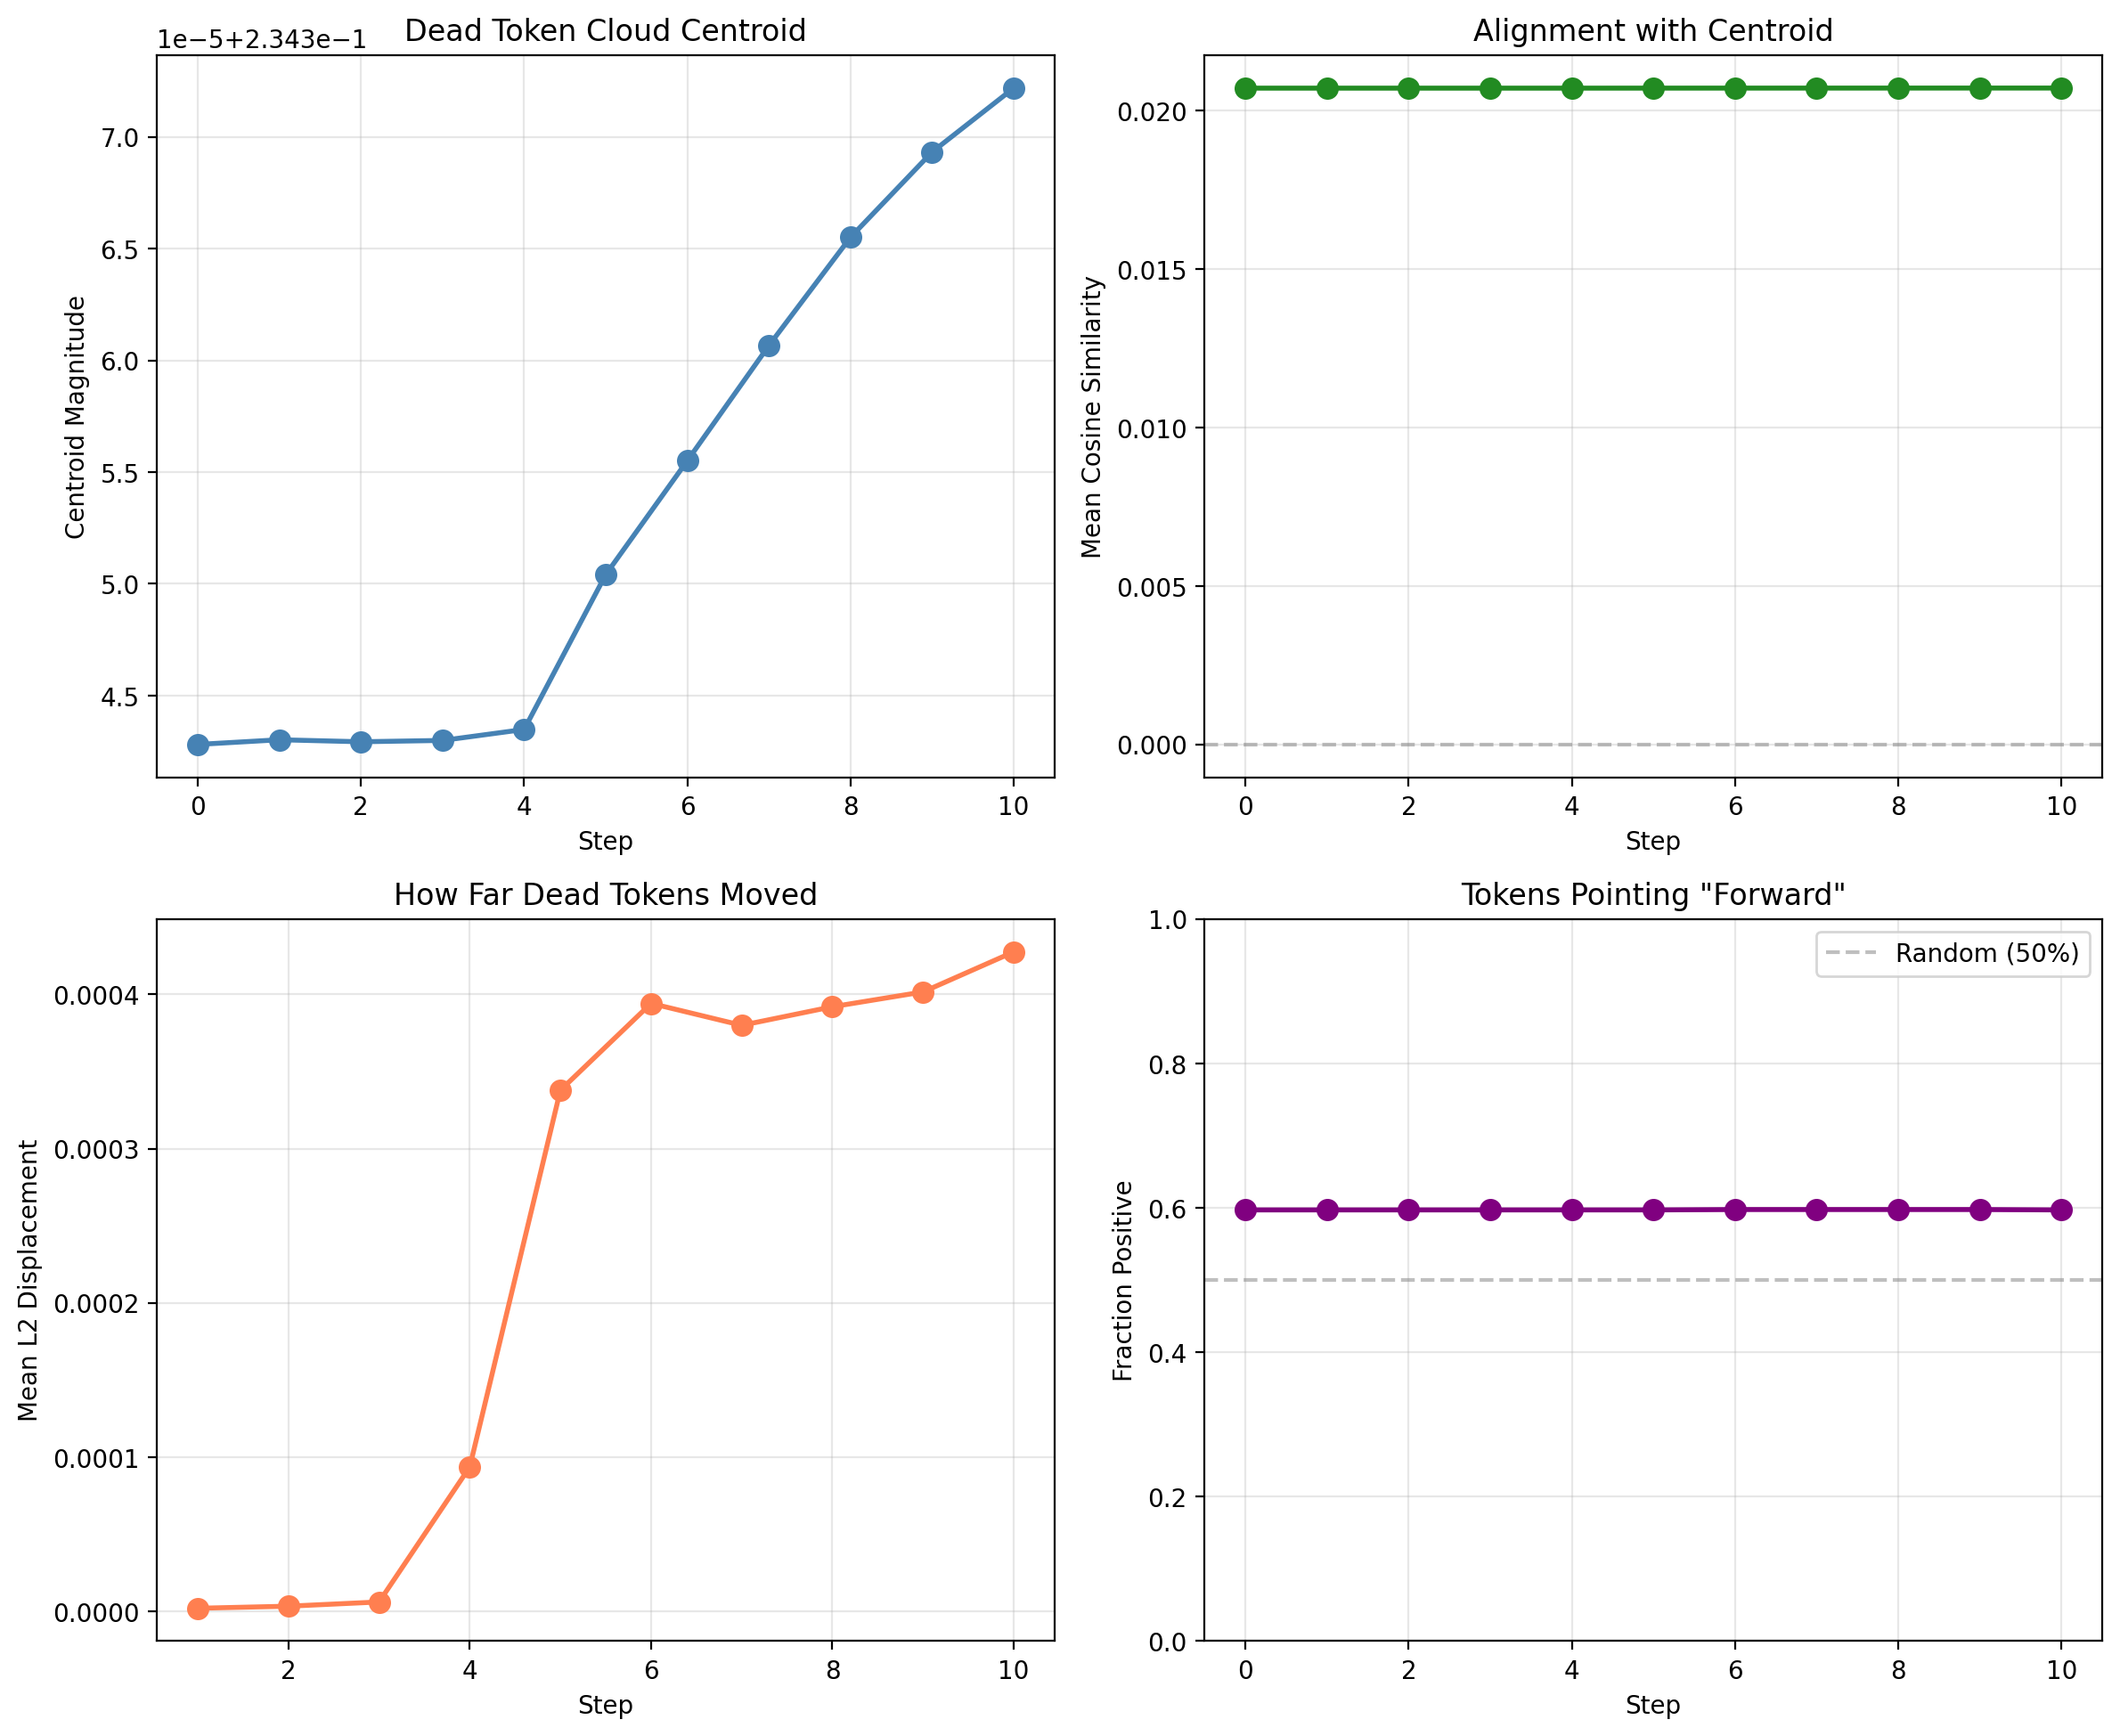

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=200)

# Plot 1: Centroid magnitude over time
ax1 = axes[0, 0]
centroid_mags = [c.norm().item() for c in centroids]
ax1.plot(range(len(centroids)), centroid_mags, 'o-', color='steelblue', linewidth=2, markersize=8)
ax1.set_xlabel('Step')
ax1.set_ylabel('Centroid Magnitude')
ax1.set_title('Dead Token Cloud Centroid')
ax1.grid(True, alpha=0.3)

# Plot 2: Mean cosine to centroid
ax2 = axes[0, 1]
mean_cos = [s['mean'] for s in cos_to_centroid_stats]
ax2.plot(range(len(mean_cos)), mean_cos, 'o-', color='forestgreen', linewidth=2, markersize=8)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Step')
ax2.set_ylabel('Mean Cosine Similarity')
ax2.set_title('Alignment with Centroid')
ax2.grid(True, alpha=0.3)

# Plot 3: L2 displacement
ax3 = axes[1, 0]
mean_l2 = [s['mean'] for s in l2_stats]
steps = range(1, len(l2_stats) + 1)
ax3.plot(steps, mean_l2, 'o-', color='coral', linewidth=2, markersize=8)
ax3.set_xlabel('Step')
ax3.set_ylabel('Mean L2 Displacement')
ax3.set_title('How Far Dead Tokens Moved')
ax3.grid(True, alpha=0.3)

# Plot 4: Fraction with positive cosine to centroid
ax4 = axes[1, 1]
frac_pos = [s['frac_positive'] for s in cos_to_centroid_stats]
ax4.plot(range(len(frac_pos)), frac_pos, 'o-', color='purple', linewidth=2, markersize=8)
ax4.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random (50%)')
ax4.set_xlabel('Step')
ax4.set_ylabel('Fraction Positive')
ax4.set_title('Tokens Pointing "Forward"')
ax4.set_ylim(0, 1)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparison: Dead vs Live Tokens

Are dead tokens moving differently than live tokens?

In [13]:
# L2 displacement for dead vs live tokens
print("L2 Displacement Comparison:")
print(f"{'Step':<6} {'Dead Mean':<12} {'Live Mean':<12} {'Ratio':<8}")
print("-" * 40)

for t in range(1, len(W_history)):
    W_before = W_history[t-1].float()
    W_after = W_history[t].float()
    delta = W_after - W_before
    l2 = delta.norm(dim=1)
    
    dead_mean = l2[dead_token_ids].mean().item()
    live_mean = l2[live_token_ids].mean().item()
    ratio = dead_mean / live_mean if live_mean > 0 else float('inf')
    
    print(f"{t:<6} {dead_mean:<12.6f} {live_mean:<12.6f} {ratio:<8.2f}")

L2 Displacement Comparison:
Step   Dead Mean    Live Mean    Ratio   
----------------------------------------
1      0.000002     0.002677     0.00    
2      0.000003     0.001792     0.00    
3      0.000006     0.001864     0.00    
4      0.000094     0.001703     0.05    
5      0.000338     0.001817     0.19    
6      0.000394     0.001726     0.23    
7      0.000380     0.001712     0.22    
8      0.000392     0.001683     0.23    
9      0.000402     0.001687     0.24    
10     0.000427     0.001665     0.26    


## Summary

What did we see?

In [14]:
print("=" * 60)
print("SUMMARY: First 10 Steps")
print("=" * 60)

print(f"\nCentroid motion:")
print(f"  t=0 magnitude: {centroid_mags[0]:.6f}")
print(f"  t={NUM_STEPS} magnitude: {centroid_mags[-1]:.6f}")
print(f"  Total drift: {(centroids[-1] - centroids[0]).norm().item():.6f}")

print(f"\nCloud tightening:")
print(f"  t=0 mean cos to centroid: {cos_to_centroid_stats[0]['mean']:.4f}")
print(f"  t={NUM_STEPS} mean cos to centroid: {cos_to_centroid_stats[-1]['mean']:.4f}")
print(f"  t=0 fraction positive: {cos_to_centroid_stats[0]['frac_positive']*100:.1f}%")
print(f"  t={NUM_STEPS} fraction positive: {cos_to_centroid_stats[-1]['frac_positive']*100:.1f}%")

print(f"\nDisplacement decay:")
print(f"  Step 1 mean L2: {l2_stats[0]['mean']:.6f}")
print(f"  Step {NUM_STEPS} mean L2: {l2_stats[-1]['mean']:.6f}")
print(f"  Ratio: {l2_stats[0]['mean'] / l2_stats[-1]['mean']:.2f}x")

print("\n" + "=" * 60)

SUMMARY: First 10 Steps

Centroid motion:
  t=0 magnitude: 0.234343
  t=10 magnitude: 0.234372
  Total drift: 0.000814

Cloud tightening:
  t=0 mean cos to centroid: 0.0207
  t=10 mean cos to centroid: 0.0207
  t=0 fraction positive: 59.7%
  t=10 fraction positive: 59.7%

Displacement decay:
  Step 1 mean L2: 0.000002
  Step 10 mean L2: 0.000427
  Ratio: 0.00x

